In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
#Preprocessing

from tensorflow.keras.utils import image_dataset_from_directory
train_dir = './Face Mask Dataset/Train'
test_dir = './Face Mask Dataset/Test'
train_data = image_dataset_from_directory(train_dir,batch_size=32,shuffle=True,image_size=(224,224),label_mode='categorical')
test_data = image_dataset_from_directory(test_dir,batch_size=32,shuffle=False,image_size=(224,224),label_mode='categorical')

Found 10000 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


In [3]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [4]:
import datetime
def create_tensorboard_callback(dir_name,experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [5]:
data_augmentation_layer = tf.keras.models.Sequential([
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomRotation(0.2),
    
],name='data_augmentation_layer')

In [6]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224,224,3),name='Input_layer')
x = data_augmentation_layer(inputs)
x = base_model(x,training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(train_data.class_names),activation='softmax',name='output_layer')(x)
model = tf.keras.Model(inputs,outputs)

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [7]:
# Setup checkpoint path
checkpoint_path = "model/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=False, 
                                                         save_best_only=True,
                                                         monitor='val_accuracy',
                                                                                                           
                                                         verbose=1)

In [8]:
history_1 = model.fit(train_data,
epochs=5,
validation_data=test_data,
steps_per_epoch=len(train_data),
batch_size=32,
validation_steps=int(0.15*len(test_data)),
callbacks=[checkpoint_callback,create_tensorboard_callback(dir_name='tensorlogs',experiment_name='face_detection_without_fine_tuning')]
)

Saving TensorBoard log files to: tensorlogs/face_detection_without_fine_tuning/20220823-212211
Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.0762 - accuracy: 0.9769
Epoch 1: val_accuracy improved from -inf to 0.94531, saving model to model/checkpoint.ckpt


INFO:tensorflow:Assets written to: model/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: model/checkpoint.ckpt/assets


313/313 [==============================] - 113s 348ms/step - loss: 0.0762 - accuracy: 0.9769 - val_loss: 0.1135 - val_accuracy: 0.9453
Epoch 2/5
313/313 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9912
Epoch 2: val_accuracy improved from 0.94531 to 0.96875, saving model to model/checkpoint.ckpt


INFO:tensorflow:Assets written to: model/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: model/checkpoint.ckpt/assets


313/313 [==============================] - 83s 265ms/step - loss: 0.0300 - accuracy: 0.9912 - val_loss: 0.0763 - val_accuracy: 0.9688
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9945
Epoch 3: val_accuracy improved from 0.96875 to 0.99219, saving model to model/checkpoint.ckpt


INFO:tensorflow:Assets written to: model/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: model/checkpoint.ckpt/assets


313/313 [==============================] - 74s 238ms/step - loss: 0.0210 - accuracy: 0.9945 - val_loss: 0.0664 - val_accuracy: 0.9922
Epoch 4/5
313/313 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9936
Epoch 4: val_accuracy did not improve from 0.99219
313/313 [==============================] - 52s 166ms/step - loss: 0.0183 - accuracy: 0.9936 - val_loss: 0.0658 - val_accuracy: 0.9922
Epoch 5/5
313/313 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9960
Epoch 5: val_accuracy did not improve from 0.99219
313/313 [==============================] - 49s 158ms/step - loss: 0.0149 - accuracy: 0.9960 - val_loss: 0.0626 - val_accuracy: 0.9844


In [9]:
history_1

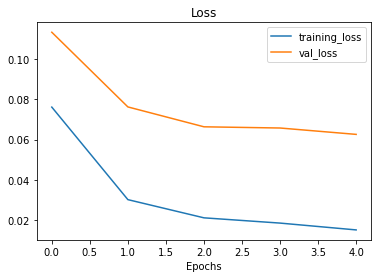

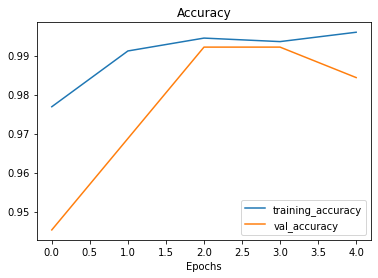

In [10]:
plot_loss_curves(history_1)

In [11]:
#Fine Tuning

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                                 
Total params: 4,052,133
Trainable params: 2,562
Non-trainable

In [17]:
saved_model = tf.keras.models.load_model(checkpoint_path)

In [18]:
saved_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                                 
Total params: 4,052,133
Trainable params: 2,562
Non-trainable

In [20]:
v_dir = './Face Mask Dataset/Validation'
validate_data = image_dataset_from_directory(v_dir,image_size=(224,224),shuffle=False,label_mode='categorical')

Found 800 files belonging to 2 classes.


In [21]:
saved_model.evaluate(validate_data)

25/25 [==============================] - 3s 83ms/step - loss: 0.0103 - accuracy: 0.9975


[0.010271641425788403, 0.9975000023841858]